<a href="https://colab.research.google.com/github/brenocsp/exoplanets-classification/blob/main/exoplanets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Exoplanetas

Breno Claudio de Sena Pimenta - 2020076858

## Introdução

Esse trabalho tem como objetivo e praticar os conceitos aprendidos na disciplina de Aprendizado de Máquina e adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na
interpretação e apresentação de resultados de experimentos.

Para isso, será utilizado um conjunto de dados de classificação binária de candidatos a exoplanetas encontrados pela sonda espacial Kepler da NASA. Nem todos os KOIs (Kepler Object of Interest) são de fato exoplanetas, alguns se
tratam de falsos positivos de origens diversas. A tarefa é classificar os esses onjetos entre exoplanetas confirmados e falsos positivos.

## Importação das bibliotecas

Inicialmente é feito o carregamento das bibliotecas necessárias e os classificadores para os experimentos.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Importação do dataset

Inicialmente realizamos a leitura dos dados do dataset escolhido. Como pode ser visto abaixo, ele contém uma coluna de nomes (kepoi_name), uma de classificação do objeto (koi_disposition) e mais 41 colunas de features. 

In [ ]:
df_completo = pd.read_csv('https://raw.githubusercontent.com/brenocsp/exoplanets-classification/main/koi_data.csv', low_memory=False)
df_completo.head(5)

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


## Preparando os dados

Para preparar os dados, é feita uma limpeza dos dados para garantir que os dados estão completos e que estão no formato desejado para que toda análise funcione corretamente. Por isso, é retirado qualquer valor nulo. Essa verifdicação não removeu nenhum dado, visto que o dataset estava completo.

Em seguida, é feita a correção do tipo da coluna de classes *koi_disposition*, visto que possui os valores *CONFIRMED* e *FALSE POSITIVE* o que pode vir a dificultar os experimentos. É feita a seguinte associação numérica às classes:

*   Classe 0: FALSE POSITIVE -> objetos que não são exoplanetas.
*   Classe 1: CONFIRMED -> objetos que são exoplanetas.

Por fim, foram criados os vetores X e Y. O vetor X contém somente os dados numéricos das features. O vetor Y contém somente os dados das classificação dos objetos. O conjunto X e Y foram divididos em dois subconjutos de treino e de validação.

In [ ]:
df = df_completo.copy()
df.dropna(inplace=True)

df['koi_disposition'] = df['koi_disposition'].replace('CONFIRMED', '1', regex=True)
df['koi_disposition'] = df['koi_disposition'].replace('FALSE POSITIVE', '0', regex=True)
df['koi_disposition'] = df['koi_disposition'].astype('int64')

X = df.copy().drop(['kepoi_name', 'koi_disposition'], axis=1).values
Y = df['koi_disposition'].values

x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2, random_state=8)

scaler = StandardScaler().fit(x_validation)
x_validation = scaler.transform(x_validation)

std_x = X.copy()
scaler = StandardScaler().fit(std_x)
std_x = scaler.transform(std_x)

## Classificadores

Para executar os experimentos serão usados os seguintes classificadores: Naive Bayes, Decision Tree, Support Vector Machines, k-Nearest Neighbors, Random Forest e Gradient Tree Boosting.

### Funções comuns

Abaixo serão apresentadas algumas funções utilizadas durante os exeperimentos.

#### Função de validação cruzada

Para treinar cada um dos modelos, será usado a validação cruzada k-fold com k=5. A função de treinamento é apresentada a seguir. Nela ocorre a z-normalização dos dados de treino e teste e retorna a média das acurárias e da revocação para cada fold.

In [ ]:
def cross_validation_score (X, Y, model, scaler=True):
  kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
  accuracy = []
  recall = []

  for train, test in kfold.split(X,Y):
    x_train_p, x_test_p = X[train], X[test]
    y_train_p, y_test_p = Y[train], Y[test]

    if scaler:
      scaler = StandardScaler().fit(x_train_p)
      x_train_p = scaler.transform(x_train_p)
      x_test_p = scaler.transform(x_test_p)
    
    model.fit(x_train_p, y_train_p)
    y_pred = model.predict(x_test_p)
    accuracy.append(metrics.accuracy_score(y_test_p, y_pred))
    recall.append(metrics.recall_score(y_test_p, y_pred))

  return accuracy, recall

#### Função para calcular métricas do conjunto de validação

In [ ]:
def calculate_validation_metrics(model):
  y_pred = model.predict(x_validation)
  accuracy = metrics.accuracy_score(y_validation, y_pred)
  recall = metrics.recall_score(y_validation, y_pred)

  return accuracy, recall

#### Função para plotar gráfico das métricas

In [ ]:
def plot_one_metrics_chart(chart, model):
  train_size = [500, 1000, 3000, 4000]
  train_sizes, train_scores, test_scores = learning_curve(model, std_x, Y, cv=5, shuffle=True, random_state=2, scoring='accuracy', train_sizes=train_size)
  
  train_mean = np.mean(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)

  chart.plot(train_sizes, train_mean, '--', color="#242F40",  label="Training")
  chart.plot(train_sizes, test_mean, color="#CCA43B", label="Cross-validation")
  chart.set_xlabel("Tamanho conjunto de treino"), chart.set_ylabel("Accuracy"), chart.legend(loc="best")

In [ ]:
def plot_metrics_charts (classifiers):
  if len(classifiers) == 1:
      plt.figure(figsize=(6, 6))
  else:
      newLen = len(classifiers)*5
      plt.figure(figsize=(newLen, 6))

  i = 1
  for name, model in classifiers:
    chart = plt.subplot(2, len(classifiers), i)
    chart.set_title(name)
    plot_one_metrics_chart(chart, model)
    i = i+1
    
  plt.tight_layout()
  plt.show()

#### Função de exibir curva ROC

In [ ]:
def plotROC(classifiers):
  plt.figure(figsize=(10, 5))
  plt.plot([0, 1], [0, 1], color="#CCA43B", lw=2, linestyle='--')
  plt.xlabel('Falso positivo'), plt.ylabel('Positivo'), plt.title('Curvas ROC')

  for name, model in classifiers:
    if hasattr(model, "decision_function"):
      y_score = model.decision_function(x_validation)
    else:
      y_score = model.predict_proba(x_validation)[:, 1]

    fpr, tpr, th = roc_curve(y_validation, y_score)
    plt.plot(fpr, tpr, lw=2, label=name)

  plt.legend(loc="lower right")
  plt.show()

### Naive Bayes

O classificador Naive Bayes é utilizado como baseline, uma vez que é o mais simples. Abaixo temos os resultados. Com esse classificador foi possível obter bons resultados iniciais no conjunto de treino e validação.

Acurácia no treino: 0.9224
Acurácia na validação: 0.9183

Revocação no treino: 0.971
Revocação na validação: 0.8865



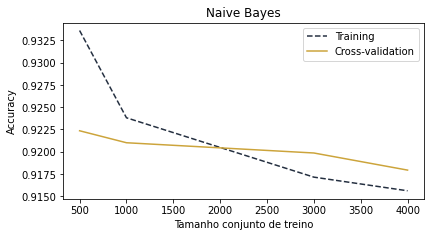

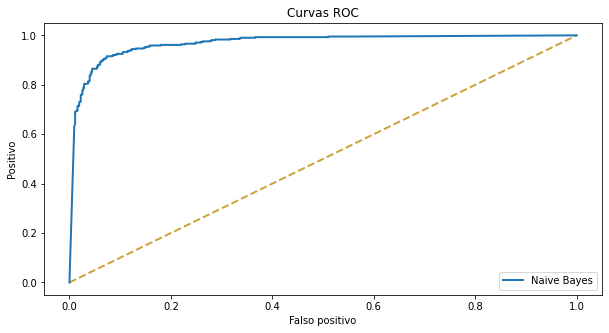

In [ ]:
classifiers = []
model = GaussianNB()
trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)
validationAccuracy, validationRecall = calculate_validation_metrics (model)

print("Acurácia no treino: {:.4}".format(np.average(trainAccuracy)))
print("Acurácia na validação: {:.4}".format(validationAccuracy))

print("\nRevocação no treino: {:.4}".format(np.average(trainRecall)))
print("Revocação na validação: {:.4}\n".format(validationRecall))

classifiers.append(['Naive Bayes', model])
plot_metrics_charts(classifiers)
plotROC(classifiers)

### Decision Tree

Para o classificador de Decision Tree, o parâmetro que foi variado foi o de tamanho da árvore, incluindo o tamanho máximo. Foi possível perceber que para valores altos de profundidade, ocorre overfitting e as métricas de acurácia e revocação caem no conjunto de validação.

Observando as curvas de precisão e ROC, observa-se que não estão numa forma esperada. Isso provavelmente ocorre devido ao aumento desnecessário da capacidade do modelo, o que causa uma perda de precisão e aumento de falsos negativos.

O melhor parâmetro para a profundidade da árvore foi 2, o qual gerou os melhores resultados no conjunto de treino e também no conjunto de validação. Alcançando valores de 0.80 de precisão e 0.94 de revocação na validação.

In [ ]:
model = DecisionTreeClassifier(random_state=0, max_depth=None)
trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)

print("O tamanho máximo da árvore é: ", model.tree_.max_depth)

O tamanho máximo da árvore é:  22


In [ ]:
decisionTreeMetrics = []
classifiers = []

for depth in [2, 4, 10, 16, 22]:
  model = DecisionTreeClassifier(random_state=4, max_depth=depth)
  trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)
  validationAccuracy, validationRecall = calculate_validation_metrics (model)
  decisionTreeMetrics.append([str(depth), np.average(trainAccuracy), np.average(trainRecall), validationAccuracy, validationRecall])
  classifiers.append(["Profundidade" + str(depth), model])

decisionTreeMetrics = pd.DataFrame(decisionTreeMetrics, columns=['Profundidade', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
decisionTreeMetrics

,Profundidade,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,2,0.912281,0.949704,0.804035,0.944444
1,4,0.947849,0.950296,0.621518,0.299517
2,10,0.952658,0.950296,0.695485,0.384058
3,16,0.951456,0.944970,0.701249,0.355072
4,22,0.947371,0.934911,0.644573,0.268116


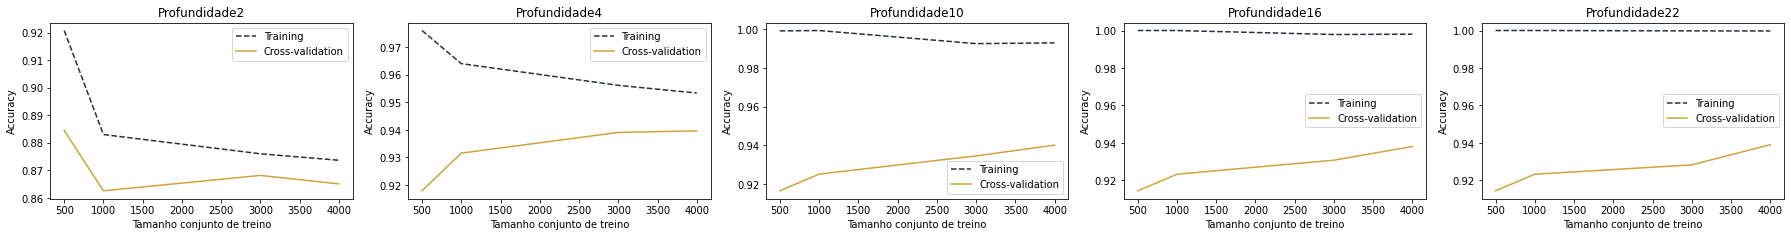

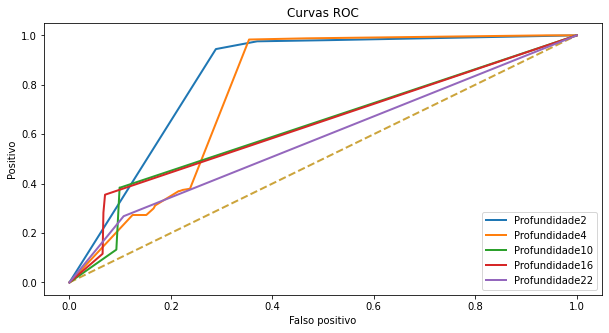

In [ ]:
plot_metrics_charts(classifiers)
plotROC(classifiers)

### Support Vector Machines

O classificador Suport Vector Machine (SVM) utiliza de uma margem que divide os pontos. O classificador posiciona o separador de forma a diminuir o erro e maximizar a margem de segurança, de acordo com o parâmetro C. Quanto maior C, maior é a penalidade e menor é a margem de segurança.

Foram realizados experimentos com quatro kernel diferentes, o linear, o polinomial, o RBF e o Sigmoid.

- **Linear:** Observa-se que esse foi o experimento com os melhores resultados de precisão e revocação no conjunto de treino e validação. Logo, isso indica que o conjutno de dados é linearmente separável.

- **Polinomial:** O Policomial também teve um desempenho mediano. O valor de revocação foi o melhor dentre os modelos, porém teve uma das piores precisões.

- **RBF:** Juntamente com o Linear, esse foi o modelo com um bom desempenho. Alcançou precisão e revocação bem similares ao modelo Linear.

- **Sigmoid:** Esse foi o modelo com a pior performance do experimento. Além de ter uma das piores medidas de precisão e revocação dentre todos os kernel e modelos até então, esse modelo não consegue melhorar seu desempenho com o aumento dos dados para aprendizado. Na curva ROC, é possível ver que é um dos piores modelos vistos.

In [ ]:
svmMetrics = []
classifiers = []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
  model = SVC(kernel= kernel, random_state=1, C=1)
  trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)
  validationAccuracy, validationRecall = calculate_validation_metrics (model)
  svmMetrics.append([kernel, np.average(trainAccuracy), np.average(trainRecall), validationAccuracy, validationRecall])
  classifiers.append(["Kernel " + str(kernel), model])

svmMetrics = pd.DataFrame(svmMetrics, columns=['Kernel', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
svmMetrics

,Kernel,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,linear,0.950973,0.960355,0.932757,0.949275
1,poly,0.872385,0.981657,0.863593,0.961353
2,rbf,0.935111,0.957988,0.923151,0.939614
3,sigmoid,0.834414,0.807692,0.846302,0.811594


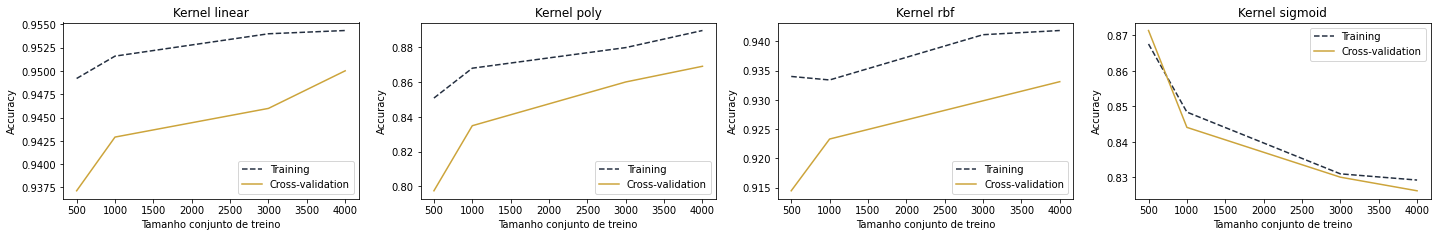

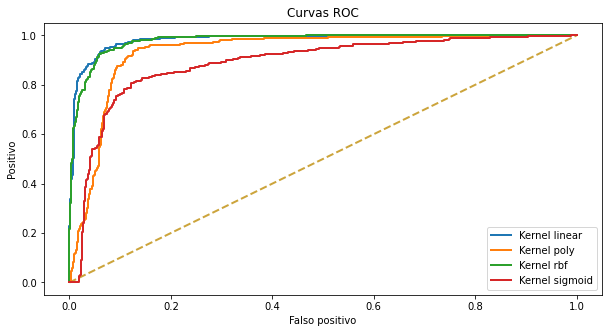

In [ ]:
plot_metrics_charts(classifiers)
plotROC(classifiers)

### k-Nearest Neighbors

Neste algoritmo foi testado algumas diferentes quantidades de vizinhos necessários para classificar um dado. O modelo performou de forma mediana. O melor parâmetro encontrado foi k=9, no qual foi possivel obter valores de 88,38% de precisão e 95,89% de revocação.

Pelos gráficos de aprendizado, é possível ver que com o aumento de vizinhos, os valores de precisão caem no conjunto de validação. A quantidade de falsos positivos para esse modelo não foi tão alta, e os diferentes números de vizinhos não tem um grande impacto nesse parâmetro.

In [ ]:
knnMetrics = []
classifiers = []

for neighbors  in [3, 9, 15, 21]:
  model = KNeighborsClassifier(n_neighbors = neighbors)
  trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)
  validationAccuracy, validationRecall = calculate_validation_metrics (model)
  knnMetrics.append([neighbors, np.average(trainAccuracy), np.average(trainRecall), validationAccuracy, validationRecall])
  classifiers.append([str(neighbors) + " Vizinhos", model])

knnMetrics = pd.DataFrame(knnMetrics, columns=['Vizinhos', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
knnMetrics

,Vizinhos,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,3,0.893778,0.960355,0.881844,0.927536
1,9,0.884165,0.972781,0.883766,0.958937
2,15,0.874792,0.972781,0.875120,0.961353
3,21,0.869025,0.972781,0.864553,0.958937


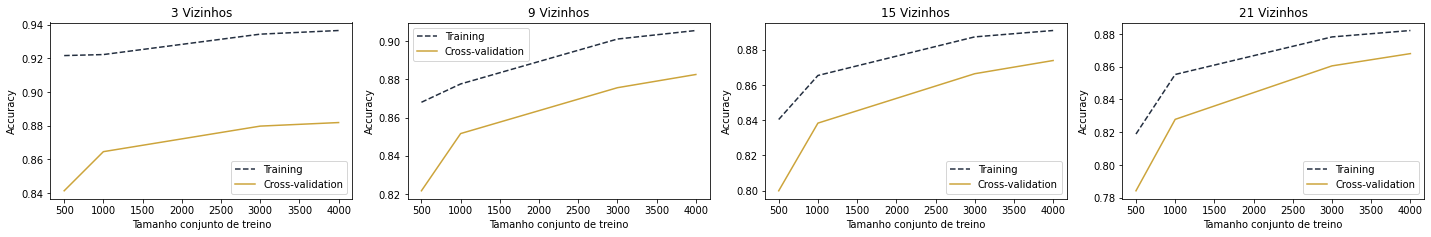

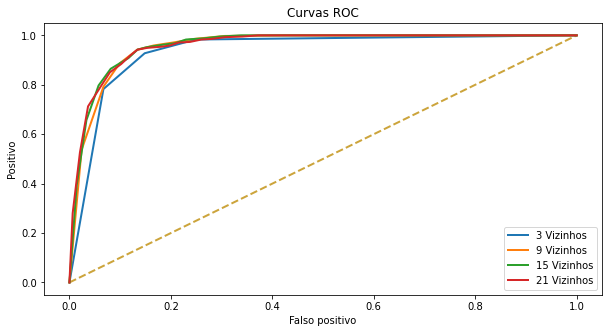

In [ ]:
plot_metrics_charts(classifiers)
plotROC(classifiers)

### Random Forest

Neste algoritmo foi variado o número de árvores. Além de ser setado o número de features e profundidade. Pode-se perceber que o algoritmo teve um bom desempenho. O parâmetro ótimo foi para 40 árvores, com tamanho máximo de 2 e 20 features.

Nessa configuraçãom o modelo apresenta uma boa curva de aprendizado. A curva ROC demonstra que ainda que se tenha uma precisão de 89,24% e revocação de 93,24%, ainda o modelo sofre com falsos positivos. Contudo, não deixa de ser um dos modelos que mais tiveram bom desempenho.

In [ ]:
rfcMetrics = []
classifiers = []

for estimator in [10, 20, 30, 40, 50]:
  model = RandomForestClassifier(n_estimators=estimator, max_depth=2, max_features=20, random_state=7)
  trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)
  validationAccuracy, validationRecall = calculate_validation_metrics (model)
  rfcMetrics.append([estimator, np.average(trainAccuracy), np.average(trainRecall), validationAccuracy, validationRecall])
  classifiers.append([str(estimator) + " Árvores", model])

rfcMetrics = pd.DataFrame(rfcMetrics, columns=['Nº Árvores', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
rfcMetrics

,Nº Árvores,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,10,0.926222,0.959763,0.871278,0.826087
1,20,0.921655,0.947929,0.871278,0.816425
2,30,0.922135,0.945562,0.888569,0.910628
3,40,0.919731,0.946154,0.892411,0.932367
4,50,0.919972,0.940237,0.891451,0.915459


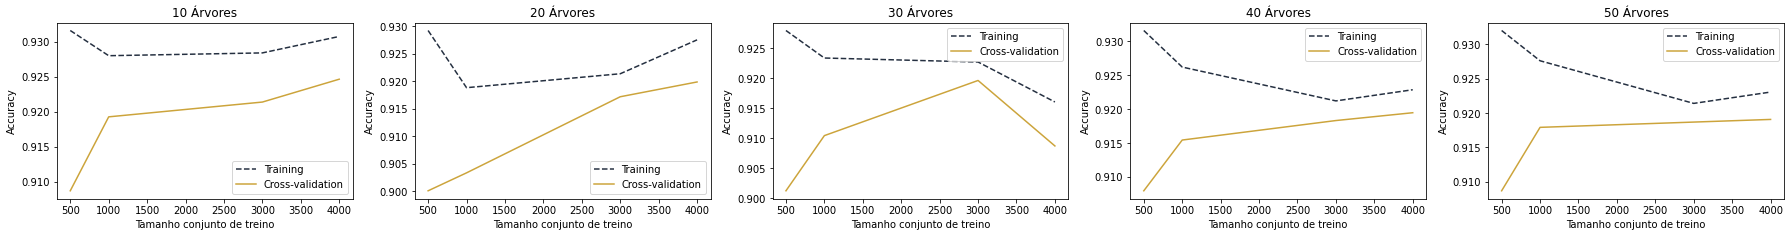

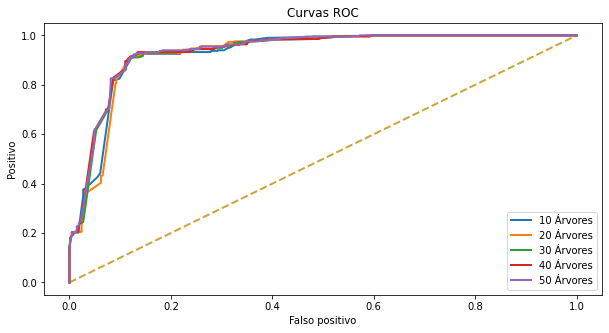

In [ ]:
plot_metrics_charts(classifiers)
plotROC(classifiers)

### Gradient Tree Boosting

Nesse modelo, foi variado o número de iterações. Esse parâmetro indica a quantidade de árvores incluídas no modelo, no qual cada árvore é responsável pelos dados que o anterior errou. De maneira geral, o algoritmo não apresentou um bom resultado no conjunto de validação, apesar de ter tido ótimos resultados no conjunto de treino. Não foi possível entender o que levou a essa grande diferença de performance. O melhor parâmetro para o algoritmo foi de 100 iterações. A curva ROC apresenta resultados bem ruins, pois possui muitos falso positivos a medida que a precisão cresce.

In [ ]:
gradientBootingMetrics = []
classifiers = []

for estimator in [40, 60, 80, 100]:
  model =  GradientBoostingClassifier(n_estimators=estimator, random_state=9)
  trainAccuracy, trainRecall = cross_validation_score (x_train, y_train, model, scaler=True)
  validationAccuracy, validationRecall = calculate_validation_metrics (model)
  gradientBootingMetrics.append([estimator, np.average(trainAccuracy), np.average(trainRecall), validationAccuracy, validationRecall])
  classifiers.append([str(estimator) + " Iterações", model])

gradientBootingMetrics = pd.DataFrame(gradientBootingMetrics, columns=['Iterações', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
gradientBootingMetrics

,Iterações,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,40,0.966356,0.962130,0.682037,0.280193
1,60,0.968038,0.965680,0.701249,0.299517
2,80,0.969480,0.967456,0.703170,0.297101
3,100,0.970922,0.968639,0.707012,0.304348


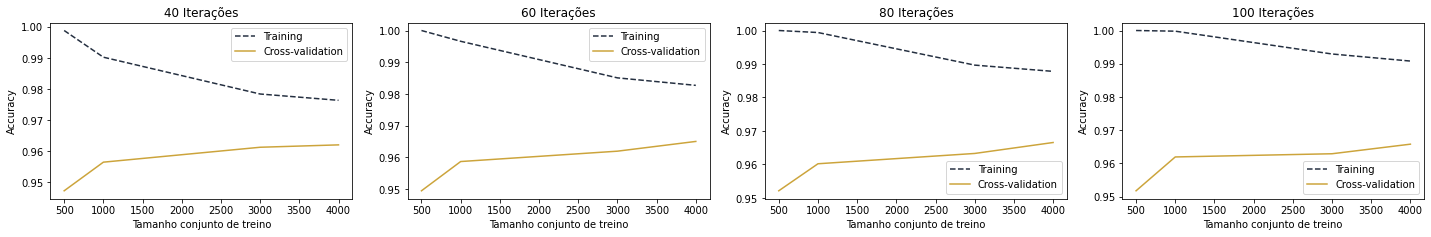

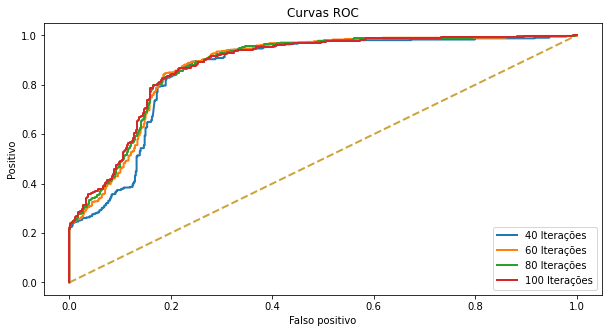

In [ ]:
plot_metrics_charts(classifiers)
plotROC(classifiers)

## Conclusão

Ao fim dos experimentos foi possível entender quais algoritmos tiveram as melhores e piores performances. Considerando a performance no conjunto de validação com os dados de precisão e revocação, os melhores foram: 

1. Support Vector Machine (0.933	0.949)
2. Naive Bayes (0.971, 0.887)
3. Random Forest (0.892,	0.932)
4. k-Nearest-Neighbor (0.884, 0.959)
5. Decision Tree (0.804, 0.944)
6. Gradient Tree Boosting (0.707, 0.304)

## Referências bibliográficas:

Foram estudados conteúdos disponíveis nos seguintes sites para entendimento do trabalho e solução de dúvidas:

* https://towardsdatascience.com/understanding-random-forest-58381e0602d2
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
* https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
* https://thecleverprogrammer.com/2020/09/22/standardscaler-in-machine-learning/
* https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
* https://github.com/eduhdm/UFMG-machine-learning-tp1/blob/master/TP1-Notebook.ipynb
* https://github.com/gustavohpgodinho/ml_trabalho_1/blob/main/notebook_trabalho1_machine_learning.ipynb


